# Описание проекта: телекоммуникации
Оператор связи **«ТелеДом»** хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**
+ Оператор предоставляет два основных типа услуг: 
+ Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
+ Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**
+ Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
+ Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
+ Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
+ Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- **contract_new.csv** — информация о договоре;
- **personal_new.csv** — персональные данные клиента;
- **internet_new.csv** — информация об интернет-услугах;
- **phone_new.csv** — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Файл **contract_new.csv**
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл **personal_new.csv**
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл **internet_new.csv**
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл **phone_new.csv**
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

In [69]:
!pip install phik

In [70]:
!pip install apyori

In [71]:
import numpy as np 
import re
import os

import pandas as pd
import random
from apyori import apriori
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [72]:
RANDOM_STATE = 220925

In [73]:
def read_files(file_name):
    
    data = pd.DataFrame()
    
    path_1 = 'datasets/' + file_name + '.csv'
    path_2 = '/datasets/' + file_name + '.csv'
    path_3 = 'https://code.s3.yandex.net/datasets/' + file_name + '.csv'
    
    if os.path.exists(path_1):
        data = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2)
    elif os.path.exists(path_3):
        data = pd.read_csv(path_3)
    
    return data

## Предобработка данных

### Обработка столбца contract_new

In [74]:
contract_new = read_files('contract_new')

In [75]:
contract_new.info()
contract_new.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [76]:
for i in contract_new.columns:
    print(f'Признак {i} имеет количество уникальных значений: {len(contract_new[i].unique())}')
    print(contract_new[i].unique())

Признак customerID имеет количество уникальных значений: 7043
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Признак BeginDate имеет количество уникальных значений: 77
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '

In [77]:
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'], format='%Y-%m-%d')

Мы полагаем, что пропуски в столбце **TotalCharges** означают, что пользователи ничего не оплачивали, следовательно можно заменить это значенеие на **0**. В противном случае мы не сможем сменить тип данных на релевантный **float64**

In [78]:
contract_new.loc[contract_new['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype('float64')

In [79]:
contract_new['churn_rate'] = 0
contract_new.loc[contract_new['EndDate'] == 'No', 'churn_rate'] = 1

In [80]:
contract_new.loc[contract_new['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'], format='%Y-%m-%d')

In [81]:
contract_new['duration_contract'] = (contract_new['EndDate'] - contract_new['BeginDate']).dt.components.days

In [82]:
contract_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in contract_new.columns] 
contract_new = contract_new.rename(columns={'customer_i_d':'customer_id'})

contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn_rate         7043 non-null   int64         
 9   duration_contract  7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


### Обработка столбца personal_new.csv

In [83]:
personal_new = read_files('personal_new')

In [84]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [85]:
for i in personal_new:
    print(f'В столбцах {i} кол-во уникальных значений: {len(personal_new[i].unique())}')
    print(personal_new[i].unique())

В столбцах customerID кол-во уникальных значений: 7043
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
В столбцах gender кол-во уникальных значений: 2
['Female' 'Male']
В столбцах SeniorCitizen кол-во уникальных значений: 2
[0 1]
В столбцах Partner кол-во уникальных значений: 2
['Yes' 'No']
В столбцах Dependents кол-во уникальных значений: 2
['No' 'Yes']


In [86]:
personal_new['SeniorCitizen'] = personal_new['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [87]:
personal_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in personal_new.columns] 
personal_new = personal_new.rename(columns={'customer_i_d':'customer_id'})

personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


### Обработка столбца internet_new.csv

In [88]:
internet_new = read_files('internet_new')

In [89]:
internet_new.info()
internet_new.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [90]:
for i in internet_new:
    print(f'В столбцах {i} кол-во уникальных значений: {len(internet_new[i].unique())}')
    print(internet_new[i].unique())

В столбцах customerID кол-во уникальных значений: 5517
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
В столбцах InternetService кол-во уникальных значений: 2
['DSL' 'Fiber optic']
В столбцах OnlineSecurity кол-во уникальных значений: 2
['No' 'Yes']
В столбцах OnlineBackup кол-во уникальных значений: 2
['Yes' 'No']
В столбцах DeviceProtection кол-во уникальных значений: 2
['No' 'Yes']
В столбцах TechSupport кол-во уникальных значений: 2
['No' 'Yes']
В столбцах StreamingTV кол-во уникальных значений: 2
['No' 'Yes']
В столбцах StreamingMovies кол-во уникальных значений: 2
['No' 'Yes']


In [91]:
internet_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in internet_new.columns] 
internet_new = internet_new.rename(columns={'customer_i_d':'customer_id'})
internet_new = internet_new.rename(columns={'streaming_t_v':'streaming_tv'})

internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


### Обработка столбца phone_new.csv

In [92]:
phone_new = read_files('phone_new')

In [93]:
phone_new.info()
phone_new.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [94]:
phone_new.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in phone_new.columns] 
phone_new = phone_new.rename(columns={'customer_i_d':'customer_id'})

phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод**

+ Мы привели названия всех столбцов к змеиному регистру 
+ Провели оценку на налиичие неявных дубликатов, аномальных значений и ошибок 
+ Некоторые признаки привели к правильному типу данных 
+ Добавили новый признак **churn_rate** и **duration_contract**

## Исследовательский анализ данных  

In [95]:
print('Размерность датафрейма "contract_new":', contract_new.shape)
print('Размерность датафрейма "personal_new":', personal_new.shape)
print('Размерность датафрейма "internet_new":', internet_new.shape)
print('Размерность датафрейма "phone_new"   :', phone_new.shape)

Размерность датафрейма "contract_new": (7043, 10)
Размерность датафрейма "personal_new": (7043, 5)
Размерность датафрейма "internet_new": (5517, 8)
Размерность датафрейма "phone_new"   : (6361, 2)


In [96]:
personal_new.join(contract_new.set_index('customer_id'), on='customer_id', how='outer').shape

(7043, 14)

Кол-во объектов совпадает, следовательно все значения сходятся и мы можем начать объединять все таблицы в один **total_ct**

In [97]:
total_cl = personal_new.join(contract_new.set_index('customer_id'), on='customer_id')
total_cl = total_cl.join(internet_new.set_index('customer_id'), on='customer_id', how = 'left')
total_cl = total_cl.join(phone_new.set_index('customer_id'), on='customer_id', how = 'left')

In [98]:
total_cl = total_cl.fillna('NaN')

In [99]:
total_cl.info()
total_cl.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   object        
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   datetime64[ns]
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7043 non-null   float64       
 12  churn_rate         7043 non-null   int64         
 13  duration_contract  7043 non-null   int64         
 14  internet

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,churn_rate,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,1,31,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,1,1036,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,1,123,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,1,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,...,1,153,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,Female,No,No,No,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,...,1,337,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,Male,No,No,Yes,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),...,1,671,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,Female,No,No,No,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,...,1,306,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,Female,No,Yes,No,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,...,1,945,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,Male,No,No,Yes,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),...,0,882,DSL,Yes,Yes,No,No,No,No,No


In [100]:
total_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   object        
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   datetime64[ns]
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7043 non-null   float64       
 12  churn_rate         7043 non-null   int64         
 13  duration_contract  7043 non-null   int64         
 14  internet

Признаки **begin_date** и **end_date** нам следует удалить, так как это будет искусственно завышенная точность на исторических данных

In [101]:
total_cl = total_cl.drop(['begin_date', 'end_date'], axis=1)

Сначала оценим распределение **monthly_charges** и **total_charges**

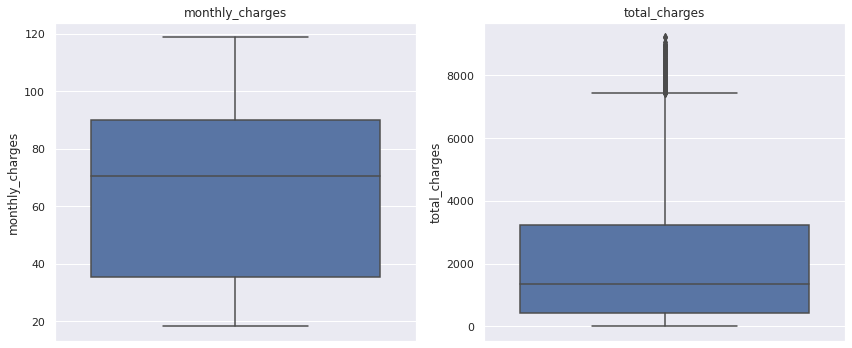

In [102]:
boxplot_list = ['monthly_charges', 'total_charges']
fig, axes = plt.subplots(1, len(boxplot_list), figsize=(12, 5))

for i, col in enumerate(boxplot_list):
    sns.boxplot(data=total_cl, y=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

- Медианное значение **monthly_charges** составляет 70, а размах максимального и минимального значения от 20 до 120. 
- Медианное значение **total_charges** примерно 1100, а размах максимального и минимального значения примерно от 0 до 7200, далее уже идут аномально высокие значения 

In [103]:
total_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   type               7043 non-null   object 
 6   paperless_billing  7043 non-null   object 
 7   payment_method     7043 non-null   object 
 8   monthly_charges    7043 non-null   float64
 9   total_charges      7043 non-null   float64
 10  churn_rate         7043 non-null   int64  
 11  duration_contract  7043 non-null   int64  
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

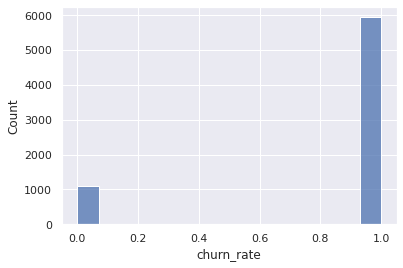

In [104]:
sns.histplot(data=total_cl, x='churn_rate')
plt.show()

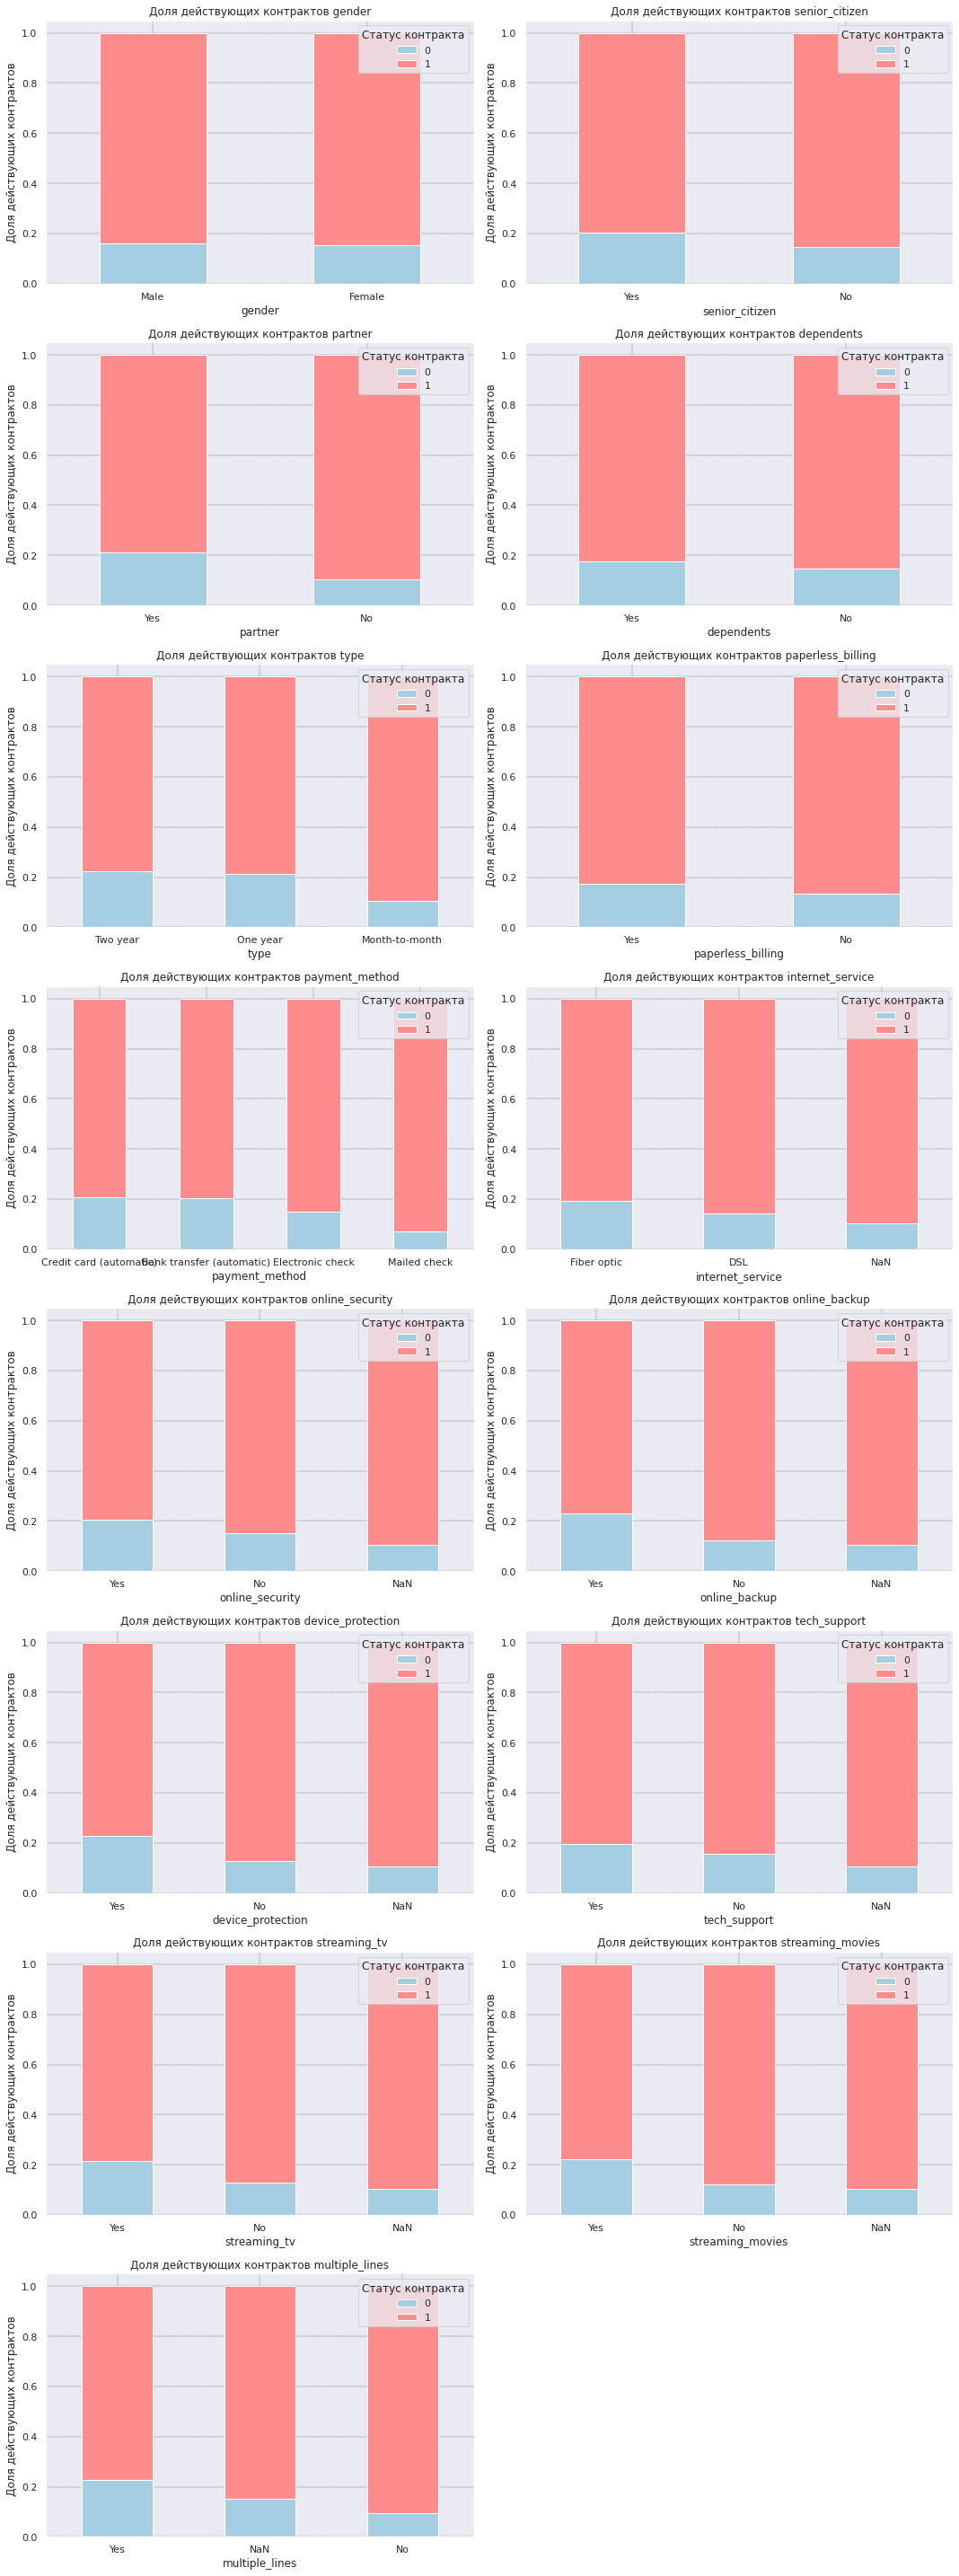

In [105]:
columns_to_plot = ['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method',
                  'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
                  'streaming_tv', 'streaming_movies', 'multiple_lines']

num_rows = (len(columns_to_plot) + 1) // 2  
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows)) 
colors = ['#a6cee3', '#ff8c8c'] 

for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col] if num_rows > 1 else axes[col]

    quit_by_column = total_cl.groupby(column)['churn_rate'].value_counts(normalize=True).unstack()
    available_values = quit_by_column.columns.tolist()
    sort_column = 0 if 0 in available_values else available_values[0]
    quit_by_column_sorted = quit_by_column.sort_values(sort_column, ascending=False)
    
    quit_by_column_sorted.plot(kind='bar', stacked=True, ax=ax, color=colors)  # Применяем цвета
    
    ax.set_title(f'Доля действующих контрактов {column}')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Доля действующих контрактов')
    ax.legend(title='Статус контракта')
    ax.grid(True, color='black', linestyle='--', linewidth=0.3)
    ax.tick_params(axis='x', rotation=0)

if len(columns_to_plot) % 2 != 0:
    if num_rows > 1:
        fig.delaxes(axes[-1, -1])
    else:
        fig.delaxes(axes[-1])

plt.tight_layout()

**Промежуточный вывод**

Наш целевой признак - **churn_rate**. Значения **1** означают, что контракт пользователя действует на момент актуальной даты, предоставленной заказчиком, значения **0** напротив означают, что контракт истек  

+ **gender:** Данный признак не впредставляет ценности, никакой корелляции статуса контракта с полом пользователя нет
+ **senior_citizen:** Можем заметить, что доля пожилых пользователей с истекших сроком контракта незначительно больше. Это может быть обусловлено тем, что пожилые пользователи забывают продлить контракт с оператором. 
+ **pather:** Доля пользователей с супругом/супругой с истекшим контрактом в 2 раза превышает долю пользователей без супруга/супруги. Это может быть объяснено тем, что пользователь с супругом/супругой полагается, что контракт уже продлен супругом/супругой и не продляет его самостоятельно. 
+ **dependents:** Доля пользователей с детьми с истекшим сроком контракта незначительно превышает аналогичную категорию пользователей с активным контрактом. 
+ **type:** Можем наблюдать весомую разницу в долях разных типов оплаты. Среди длительных контрактов на 1-2 года намного больше истекших, нежели среди помесячных контактов. Это легко объяснимо тем, что пользователь за длительный период забывает о продлении контракта. 
+ **paperless_billing:** Почти одинаковые доли истекших контрактов с электронным расчётным листом и без него
+ **payment_method:** Примерно равные доли среди всех способов оплаты, выбивается только **mailed check**. 

Далее идет анализ признаков, где довольно много пропусков. Мы не можем наверняка сказать причину, по которой так много пропусков, а потому мы не сможем заполнить/убрать их. Кроме того, тенденция схожа примерно в каждом из представленных графиков, а потому мы просто сделаем вывод по кластеру услуг целиком. 

+ **internet_service:** Среди доли истекших контрактов по распределению типов подключения превалирует подключение по оптоволокну. 
+ Охватываем все услуги, в каждом из вариантов тенденция сигнализирует о том, что доля истекших контрактов среди тех, кто подключил услугу больше, чем среди тех, кто не подключил. Это довольно легко объяснить: пользователь мог просто решить, что определенная услуга больше ему не нужна и не продлять контракт

Мы уже можем составить примерный портрет клиента, который с большей вероятностью прервет контракт с оператором: Это пожилой пользователь в браке с долгосрочным типом оплаты (на 1-2 года), при этом оплата осуществлялась либо автоматически, либо кредитной картой. 

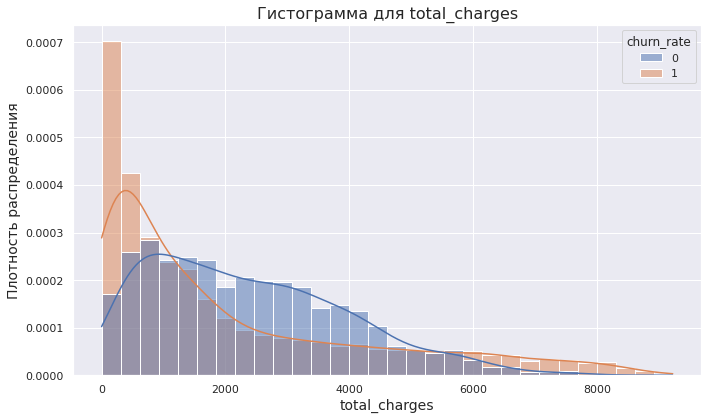

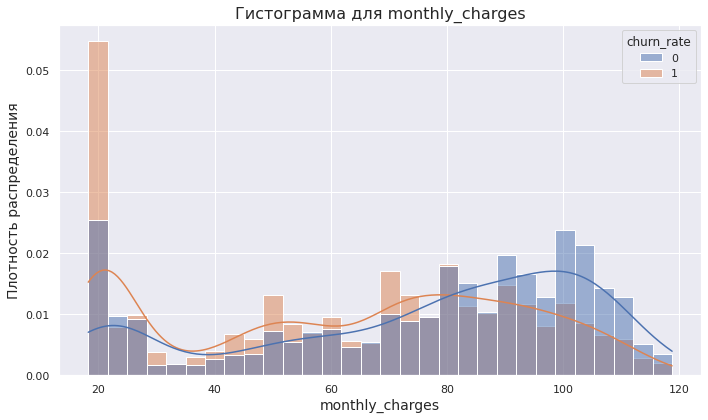

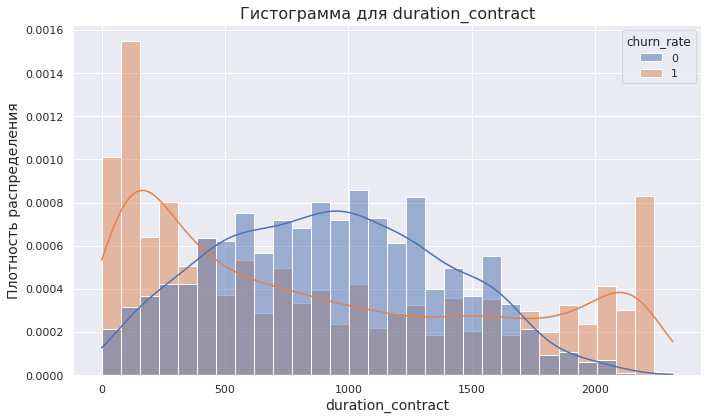

In [106]:
def plot_histogram(data, column, hue_column='churn_rate', 
                   title=None, xlabel=None, ylabel='Плотность распределения', 
                   figsize=(10, 6), bins=30, kde=True):
    sns.set()
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    
    sns.histplot(data=data, x=column, hue=hue_column, bins=bins, 
                 kde=kde, stat='density', common_norm=False, ax=ax)
    plt.tight_layout()
    plt.show()

plot_histogram(total_cl, 'total_charges', title='Гистограмма для total_charges')
plot_histogram(total_cl, 'monthly_charges', title='Гистограмма для monthly_charges')
plot_histogram(total_cl, 'duration_contract', title='Гистограмма для duration_contract')

**total_charges:**

+ Абоненты с активными контрактами демонстрируют более высокую плотность в области средних и высоких значений расходов. Это может быть связано с тем, что они дольше пользуются услугами и продолжают пополнять свой баланс.
+ Клиенты с истёкшими контрактами имеют пик плотности в области низких и средних значений, что может указывать на то, что они либо ушли раньше, либо реже пользовались платными услугами.
+ Для истекших контрактов пик смещён влево (низкие значения), это может быть связано с оттоком малоплатящих клиентов или с тем, что они не успели накопить большие расходы до расторжения контракта. Это свидетельствует о том, что эти клиенты с низкой вовлеченностью, либо являются новыми, а значит риск оттока довольно высокий.

**monthly_charges:**

+ Оба распределения имеют многомодальный характер с несколькими пиками, что свидетельствует о наличии различных тарифных планов. Основные пики сосредоточены в диапазоне 20-40 и 80-100 условных единиц.
+ Мы можем заметить, что клиенты с высокими ежемесячными платежами чаще уходят, а с среднебюджетной категории чаще остаются. 


**duration_contract:**

+ Распределение продолжительности истекших контрактов очень сильно напоминает нормальное. 1000 - это пик, далее идет спад плотности продолжительности тарифа. 
+ Мы видим два пика действующих контрактов в начале (что закономерно, пользователь только оформил контракт) и на дистанции, что означает довольно неплохое удержание в долгосрочной перспективе. 

In [107]:
total_cl.head(15)

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_rate,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,One year,No,Mailed check,56.95,2071.84,1,1036,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,Female,No,No,No,Month-to-month,Yes,Electronic check,99.65,1150.96,1,337,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,Male,No,No,Yes,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,671,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,Female,No,No,No,Month-to-month,No,Mailed check,29.75,300.48,1,306,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,Female,No,Yes,No,Month-to-month,Yes,Electronic check,104.80,3573.68,1,945,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,Male,No,No,Yes,One year,No,Bank transfer (automatic),56.15,1628.35,0,882,DSL,Yes,Yes,No,No,No,No,No


<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Установка и обновление модулей долдны быть в начале проекта
</div>

  <div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил.</div>

Оценим мультиколлинеарность данных. Сильно мультиколлинеарные признаки и признаки со слабой значимостью коллиенарности мы исключим из общего датафрейма. 

In [108]:
total_new_numeric = ['monthly_charges', 'total_charges', 'duration_contract']

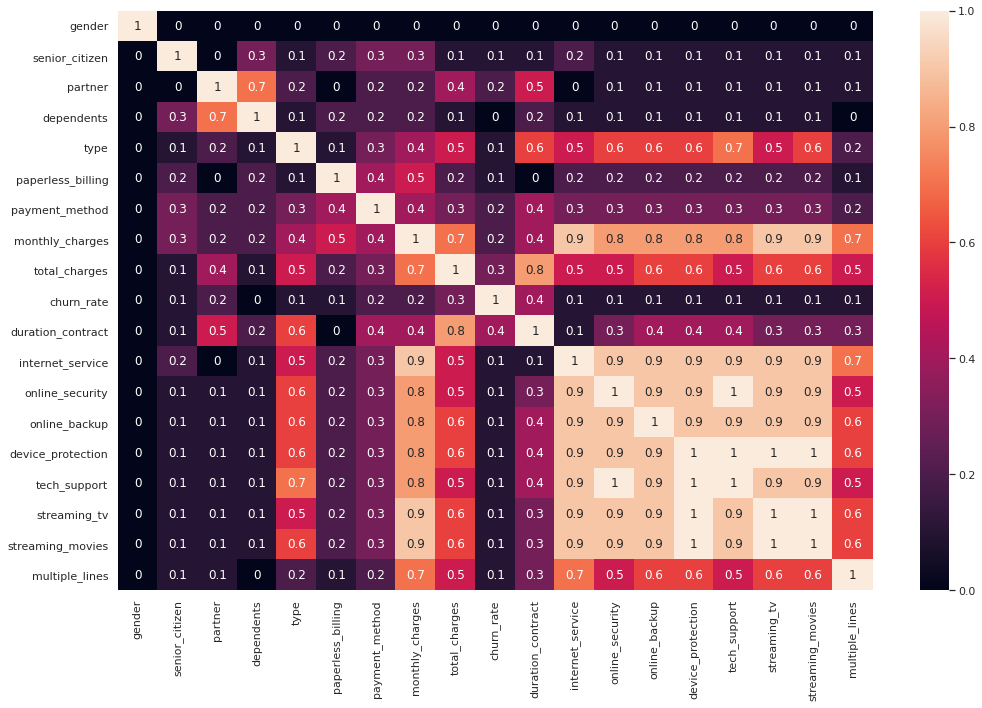

In [109]:
plt.figure(figsize=(15, 10))  

multicollinearity = total_cl.drop('customer_id', axis=1).phik_matrix(interval_cols=total_new_numeric)

sns.heatmap(multicollinearity.copy().round(1), annot=True)
plt.tight_layout()  
plt.show()

Наиболее кореллированные признаки с **churn_rate: total_charges** и **duration_contract**
+ monthly_charges (корреляция с таргетом 0.2, но есть мультиколлинеарность с интернет-услугами)
+ partner (0.2, нет сильной корреляции с другими)
+ payment_method (0.2, нет сильной мультиколлинеарности)
+ type (связь с **total_charges**)
+ online_backup (связь с type)

Мы исключим из датасета мультиколлениарные относительно друг друга интернет услуги

In [110]:
total_cl

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_rate,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,One year,No,Mailed check,56.95,2071.84,1,1036,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,Yes,One year,Yes,Mailed check,84.80,2035.20,1,730,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7430.40,1,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,No,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,325.60,1,337,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,Yes,Yes,No,Month-to-month,Yes,Mailed check,74.40,520.80,1,215,Fiber optic,No,No,No,No,No,No,Yes


In [111]:
total_cl = total_cl.drop(['online_security', 'customer_id', 'internet_service',  'online_backup',
                          'device_protection', 'tech_support', 'streaming_tv',
                          'streaming_movies', 'multiple_lines'], axis = 1)

Проанализирум отток и активность клиентов. Но сначала посмотрим на дисбаланс данных

In [112]:
# print("АНАЛИЗ ДИСБАЛАНСА ДАННЫХ")
# services_columns = [
#     'online_security', 
#     'online_backup', 
#     'device_protection', 
#     'tech_support', 
#     'streaming_tv', 
#     'streaming_movies',
#     'churn_rate'  
# ]
# services_data = total_cl[services_columns].copy()
# contract_distribution = services_data['churn_rate'].value_counts()
# print("Распределение контрактов:")
# print(contract_distribution)

Можем заметить, что значительно больше действующих контрактов, нежели истекших, а потому что анализа нужно провести стратификацию 

**Вывод:**


+ Самое сильное правило оттока клиентов - отсуствие техподдержки. У пользователя могут быть подключены различные услуги, но если отсутсвует техподдержка, то шанс оттока довольно велик (40%) и в 2 раза превышает случайный. 
+ Наиболее сильное правило активности - отсуствие каких-либо услуг. Это категория пользователей довольно крупная - 20%, шанс того что они остануться составляет 55%

## Подготовка данных

+ Мы применим к категориальным признакам кодирование OHE 
+ Для количественных признаков мы применим масштабирование 
+ Мы не будем учитывать признаки, содержащие булевые значения 

In [119]:
total_cl

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_rate,duration_contract
0,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,1,31
1,Male,No,No,No,One year,No,Mailed check,56.95,2071.84,1,1036
2,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,1,123
3,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371
4,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,1,153
...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,One year,Yes,Mailed check,84.80,2035.20,1,730
7039,Female,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7430.40,1,2191
7040,Female,No,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,325.60,1,337
7041,Male,Yes,Yes,No,Month-to-month,Yes,Mailed check,74.40,520.80,1,215


In [120]:
X = total_cl.drop(['churn_rate'], axis = 1)
y = total_cl['churn_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=RANDOM_STATE)

In [121]:
def pipeline_learning(model, model_name, parameters):
    transformer = ColumnTransformer([
        ('num', scaler, numeric_cols),
        ('cat', encoder, categorical_cols)
    ])
    
    pipe = make_pipeline(transformer, model)
    
    grid = GridSearchCV(
        pipe,
        parameters,
        verbose=3,
        cv=5,
        n_jobs=-1,
        scoring='roc_auc'
    )
    
    grid.fit(X_train, y_train)
    
    best_score = grid.best_score_
    best_model = grid.best_estimator_[1]
    
    print('\n')
    print('Лучшая модель:')
    print(best_model)
    print('Значение AUC-ROC на кросс-валидации:', round(best_score, 3))
    return best_model, best_score

In [122]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')
scoring = 'roc_auc'

In [123]:
total_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   object 
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   type               7043 non-null   object 
 5   paperless_billing  7043 non-null   object 
 6   payment_method     7043 non-null   object 
 7   monthly_charges    7043 non-null   float64
 8   total_charges      7043 non-null   float64
 9   churn_rate         7043 non-null   int64  
 10  duration_contract  7043 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 605.4+ KB


In [124]:
categorical_cols = [
    'type', 'payment_method', 'gender', 
    'paperless_billing', 'senior_citizen',
    'partner', 'dependents'
]
numeric_cols = ['total_charges', 'duration_contract', 'monthly_charges']

## Обучение моделей

Перейдем к обучению моделей. Мы рассмотрим:
+ LogisticRegression
+ DecisionTreeClassifier;
+ RandomForestClassifier
+ LGBMCLassifier;
+ CatBoostClassifier;

In [125]:
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log_reg_params = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', None],
    'logisticregression__solver': ['liblinear', 'saga']
}

best_log_reg, best_log_reg_score = pipeline_learning(log_reg, 'LogisticRegression', log_reg_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV 2/5] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.2s
[CV 3/5] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.2s
[CV 4/5] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.2s
[CV 5/5] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.2s
[CV 1/5] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=saga; total time=   0.2s
[CV 2/5] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=saga; total time=   0.2s
[CV 3/5] END logisticregression

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warning

[CV 3/5] END logisticregression__C=0.001, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=0.001, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=0.001, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=0.001, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=0.001, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=0.001, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 4/5] END logisticregression__C=0.001, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 5/5] END logisticregression__C=0.001, logis

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'no

[CV 3/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 4/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 5/5] END logisticregression__C=0.001, logisticregression__penalty=None, logisticregre

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warning

[CV 3/5] END logisticregression__C=0.01, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=0.01, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=0.01, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=0.01, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 5/5] END logisticregression__C=0.01, logisticregre

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'no

[CV 3/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 5/5] END logisticregression__C=0.01, logisticregression__penalty=None, logisticregression__s

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warning

[CV 1/5] END logisticregression__C=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.2s
[CV 2/5] END logisticregression__C=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=0.1, logisticreg

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'no

[CV 1/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 2/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=0.1, logisticregression__penalty=None, logisticregression_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warning

[CV 1/5] END logisticregression__C=1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.2s
[CV 2/5] END logisticregression__C=1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=1, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=1, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=1, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=1, logisticregression__penalty

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'no

[CV 1/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 2/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=1, logisticregression__penalty=None, logisticregression__solver=saga; to

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warning

[CV 1/5] END logisticregression__C=10, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.2s
[CV 2/5] END logisticregression__C=10, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=10, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=10, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=10, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=10, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=10, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=10, logisticregression_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'no

[CV 2/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 4/5] END logisticregression__C=10, logisticregression__penalty=None, logisticregression__solver=saga;

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 450, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warning

[CV 1/5] END logisticregression__C=100, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.2s
[CV 2/5] END logisticregression__C=100, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=100, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=100, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=100, logisticregression__penalty=elasticnet, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=100, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=100, logisticregression__penalty=elasticnet, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=100, logisticreg

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'no

[CV 1/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 2/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 3/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 4/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 5/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression__solver=liblinear; total time=   0.0s
[CV 1/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 2/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression__solver=saga; total time=   0.0s
[CV 3/5] END logisticregression__C=100, logisticregression__penalty=None, logisticregression_

In [126]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_params = {
    'decisiontreeclassifier__max_depth': range(2, 21, 2),
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

best_tree, best_tree_score = pipeline_learning(tree, 'DecisionTreeClassifier', tree_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2; total time=   0.0s
[CV 2/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2; total time=   0.0s
[CV 3/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2; total time=   0.0s
[CV 4/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2; total time=   0.0s
[CV 5/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2; total time=   0.0s
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=4; total time=   0.0s
[CV 2/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=4; total time=   0.0s
[CV 3/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=4; total time=   0.0s
[CV 4/5] END decisiontreeclassifier__criterion=gini, decisiontreec

In [127]:
%%time

forest = RandomForestClassifier(random_state=RANDOM_STATE)
forest_params = {
     'randomforestclassifier__max_depth': range(4, 10, 2),
     'randomforestclassifier__n_estimators': range(250, 351, 50),
     'randomforestclassifier__criterion': ['gini', 'entropy']
}

best_forest, best_forest_score = pipeline_learning(forest, 'RandomForestClassifier', forest_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=250; total time=   0.7s
[CV 2/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=250; total time=   0.7s
[CV 3/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=250; total time=   0.6s
[CV 4/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=250; total time=   0.7s
[CV 5/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=250; total time=   0.7s
[CV 1/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__n_estimators=300; total time=   0.8s
[CV 2/5] END randomforestclassifi

In [128]:
# %%time

# lgbm = LGBMClassifier(random_state=RANDOM_STATE)
# lgbm_params = {
#     'lgbmclassifier__max_depth': range(-10, 10, 2),
#     'lgbmclassifier__learning_rate': [0.01, 0.1, 1, 10]
# }

# best_lgbm, best_lgbm_score = pipeline_learning(lgbm, 'LGBMClassifier', lgbm_params)

In [129]:
%%time

catboost = CatBoostClassifier(loss_function='Logloss', random_seed=RANDOM_STATE, silent=True)

catboost_params = {
 'catboostclassifier__depth': [x for x in range(1, 5)],
 'catboostclassifier__iterations': [x for x in range(100, 1100, 100)],
 'catboostclassifier__learning_rate': [0.5, 0.6, 0.7]
}

best_catboost, best_catboost_score = pipeline_learning(catboost, 'CatBoostClassifier', catboost_params)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END catboostclassifier__depth=1, catboostclassifier__iterations=100, catboostclassifier__learning_rate=0.5; total time=   1.2s
[CV 2/5] END catboostclassifier__depth=1, catboostclassifier__iterations=100, catboostclassifier__learning_rate=0.5; total time=   0.7s
[CV 3/5] END catboostclassifier__depth=1, catboostclassifier__iterations=100, catboostclassifier__learning_rate=0.5; total time=   0.7s
[CV 4/5] END catboostclassifier__depth=1, catboostclassifier__iterations=100, catboostclassifier__learning_rate=0.5; total time=   0.6s
[CV 5/5] END catboostclassifier__depth=1, catboostclassifier__iterations=100, catboostclassifier__learning_rate=0.5; total time=   0.6s
[CV 1/5] END catboostclassifier__depth=1, catboostclassifier__iterations=100, catboostclassifier__learning_rate=0.6; total time=   0.9s
[CV 2/5] END catboostclassifier__depth=1, catboostclassifier__iterations=100, catboostclassifier__learning_rate=0.6; tota

In [130]:
score_data = [
    ['LogisticRegression', best_log_reg_score],
    ['DecisionTreeClassifier', best_tree_score],
    ['RandomForestClassifier', best_forest_score],
    ['CatBoostClassifier', best_catboost_score]
]

score_df = pd.DataFrame(score_data, columns=['model', 'AUC-ROC'])

score_df

,model,AUC-ROC
0,LogisticRegression,0.740381
1,DecisionTreeClassifier,0.790707
2,RandomForestClassifier,0.827466
3,CatBoostClassifier,0.925561


**Вывод**

Наилучшая модель на кросс-валидации - CatBoostClassifier.  

## Тестирование моделей

In [137]:
def pipeline_testing(model):
    if hasattr(model, 'named_steps') and isinstance(model.named_steps, dict):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
    else:
        transformer = ColumnTransformer([
            ('num', scaler, numeric_cols),
            ('cat', encoder, categorical_cols)
        ])
        transformer.fit(X_train)
        X_test_transformed = transformer.transform(X_test)

        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_transformed)[:, 1]
        elif hasattr(model, 'decision_function'):
            scores = model.decision_function(X_test_transformed)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            raise ValueError("ошибка")

        y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print(f'\nAUC-ROC на тестовой выборке: {auc:.3f}')
    print(f'Accuracy: {acc:.3f}')
    print('\nОтчёт по классам:\n', classification_report(y_test, y_pred))

    plot_roc_curve(y_test, y_proba, auc)
    plot_confusion_matrix(y_test, y_pred)
    plot_feature_importance(model)

    return y_proba, y_pred

In [132]:
def plot_roc_curve(y_true, y_proba, auc_score):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [133]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Матрица ошибок')
    plt.show()

In [134]:
def plot_feature_importance(model):
    importances = None
    feature_names = []
    if hasattr(model, 'named_steps') and isinstance(model.named_steps, dict):
        for step_name, step in model.named_steps.items():
            if hasattr(step, 'feature_importances_'):
                importances = step.feature_importances_
                break
        if 'columntransformer' in model.named_steps:
            ct = model.named_steps['columntransformer']
            feature_names = []
            for name, trans, cols in ct.transformers_:
                if hasattr(trans, 'get_feature_names_out'):
                    feature_names.extend(trans.get_feature_names(cols))
                else:
                    feature_names.extend(cols)
        else:
            feature_names = numeric_cols + categorical_cols
    else:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        feature_names = numeric_cols + categorical_cols

    if importances is not None:
        n = min(len(importances), len(feature_names))
        importances = importances[:n]
        feature_names = feature_names[:n]

        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 6))
        plt.barh(np.array(feature_names)[indices][:10][::-1], importances[indices][:10][::-1])
        plt.title('Важность признаков')
        plt.xlabel('Feature importance')
        plt.tight_layout()
        plt.show()



AUC-ROC на тестовой выборке: 0.929
Accuracy: 0.935

Отчёт по классам:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75       275
           1       0.93      0.99      0.96      1486

    accuracy                           0.94      1761
   macro avg       0.94      0.81      0.86      1761
weighted avg       0.94      0.94      0.93      1761



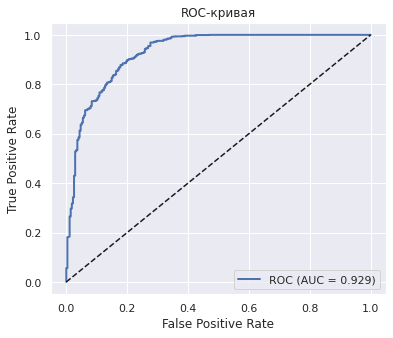

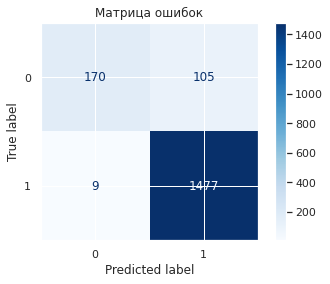

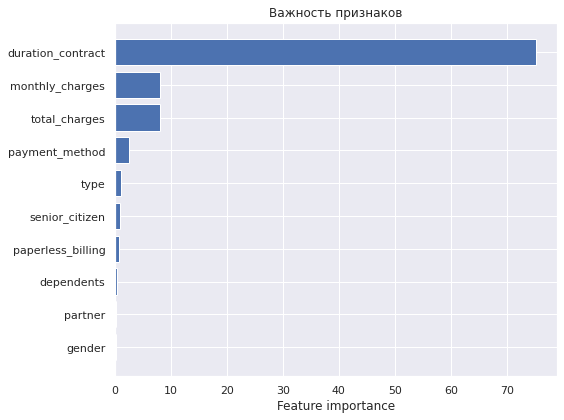

In [138]:
y_proba, y_pred = pipeline_testing(best_catboost)

Наиболее значимым признаком является **duration_contract**, что было ожидаемо. Затем идет **total_charges** и тип оплаты (два года)

+ Модель очень хорошо предсказывает действующие контракты (высокие **Precision** и **Recall**).
+ По классу 0 (истекшие) **Precision** ниже (95%), то есть когда модель говорит, что контракт истёк», она ошибается примерно 35% случаев.
+ **Recall** для класса 0 высокий (93%) — большинство действительно истекших контрактов она находит.
+ Основная проблема — 105 ложноотрицательных прогнозов (действующие контракты, предсказанные как истекшие), что может быть критично, если пропуск действующего клиента дорого стоит.

## Вывод

Предобработка данных:
+ При признаки были приведены к правильному типу данных
+ Проанализированы пропущенные значения
+ Все признаки теперь приведены к змеиному регистру

Исследовательский анализ данных:
+ Рассмотрены корреляции между различными признаками и целевой переменной
+ Построена матрица корреляций phik

Обучены различные модели машинного обучения
+ LogisticRegression
+ DecisionTreeClassifier	
+ RandomForestClassifier	
+ LGBMClassifier	
+ CatBoostClassifier	


Проанализировано качество работы каждой модели, в том числе выбрана наилучшая модель **CatBoost** c метриками на тестовой выборке
+ **AUC-ROC: 0.929**
+ **Accuracy: 0.935**
Построена матрица ошибок **CatBoostClassifier**
Построен и проанализирован график важности признаков и график ROC-AUC

**Рекомендации заказчику:**

+ Следует обратить внимание на то, что многие признаки имеют неправильные типы данных. Стоит оптимизировать алгоритм формирования базы данных для более комфортного анализа БД. 

+ Стоит обратить внимание на кластер предоставляемых услуг. Как мы уже определили, очень много клиентов разрывают контракт с оператором по причине отсутствия технической поддержки. Возможно стоит предоставлять ее сразу, а не выделять в качестве отдельной услуги, либо же предоставить пробный период. 

+ Стоит сделать рассылки, чтобы напоминать людям о необходимости продлить оплату, так как мы видели большую просадку по типу оплаты **month-to-month**